<a href="https://colab.research.google.com/github/shrutikamokashi/EAI_Assignments/blob/master/Week_4_Lab_Neural_Networks_in_Practice_Shrutika.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 4 Lab: Neural Networks in practice

In [1]:
# Global imports and settings

from IPython.display import set_matplotlib_formats, display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import keras
print("Using Keras",keras.__version__)
%matplotlib inline
plt.rcParams['figure.dpi'] = 125 # Use 300 for PDF, 100 for slides


Using TensorFlow backend.


Using Keras 2.2.5


### Overview
* Solving basic classification and regression problems
* Handling textual data
* Model selection (and overfitting)

## Solving basic problems
* Binary classification (of movie reviews)
* Multiclass classification (of news topics)
* Regression (of house prices)

Examples from _Deep Learning with Python_, by _François Chollet_

### Binary classification
* Dataset: 50,000 IMDB reviews, labeled positive (1) or negative (0)
    - Included in Keras, with a 50/50 train-test split
* Each row is one review, with only the 10,000 most frequent words retained
* Each word is replaced by a _word index_ (word ID)

In [2]:
from keras.datasets import imdb
# Download IMDB data with 10000 most frequent words
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)
print("Encoded review: ", train_data[0][0:10])

word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
print("Original review: ", ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]][0:10]))

Encoded review:  [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]
Original review:  ? this film was just brilliant casting location scenery story


In [0]:
def decode_review(a):
  word_index = imdb.get_word_index()
  reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
  print(' '.join([reverse_word_index.get(i-3, '') for i in a]))

#### Preprocessing
* We can't input lists of categorical value to a neural net, we need to create tensors
* One-hot-encoding:
    -  10000 features, '1.0' if the word occurs
* Word embeddings (word2vec):
    - Map each word to a dense vector that represents it (it's _embedding_)
    - _Embedding_ layer: pre-trained layer that looks up the embedding in a dictionary 
    - Converts 2D tensor of word indices (zero-padded) to 3D tensor of embeddings
* Let's do One-Hot-Encoding for now. We'll come back to _Embedding_ layers.
* Also vectorize the labels: from 0/1 to float
    - Binary classification works with one output node

In [0]:
# Custom implementation of one-hot-encoding
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [5]:
len(train_data[1])

189

#### Understanding the format of IMDB dataset
1. Train_data and test_data are an array of lists. What does the length of this array correspond to? What does the length of each list correspond to?
2. What are the sizes of the vectorized x_train and x_test? What do the dimensions correspond to?
3. What is the most common word in the first review in the training data? Hint: use the word index (see above)? 
4. Print the first review to verify. 

In [6]:
## 1. Train_data and test_data are an array of lists. What does the length of this array correspond to? What does the length of each list correspond to?
print("Length of train_data: "+str(len(train_data)))
print("Length of test_data: "+str(len(test_data)))


Length of train_data: 25000
Length of test_data: 25000


Length of this array corresponds to 25000 movie reviews in each of the dataset.
Length of each list correspond to the number of words present in the review.

In [7]:
## 2. What are the sizes of the vectorized x_train and x_test? What do the dimensions correspond to?
print(x_train.size)
print(x_train.shape)
print(x_test.size)
print(x_train.shape)

250000000
(25000, 10000)
250000000
(25000, 10000)


In [8]:
train_data[0][0]

1

The dimensions correspond to 25000 reviews and 10000 most frequently retained words for each review.

In [9]:
## 3. What is the most common word in the first review in the training data? Hint: use the word index (see above)? 
import collections
import operator
def CountFreq(arr): 
    return collections.Counter(arr) 

freq = CountFreq(train_data[0])
freq.keys()
max(freq.items(), key=operator.itemgetter(1))
print("Most frequent occuring word : "+reverse_word_index[4 - 3])

Most frequent occuring word : the


In [10]:
## 4. Print the first review to verify. 
decode_review(train_data[0])

 this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert  is an amazing actor and now the same being director  father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for  and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also  to the two little boy's that played the  of norman and paul they were just brilliant children are often left out of the  list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think the 

In [11]:
train_data[0].count(14)

3

#### Building the network
* We can solve this problem using a network of _Dense_ layers and the _ReLU_ activation function.
* How many layers? How many hidden units for layer?
    - Start with 2 layers of 16 hidden units each
    - We'll optimize this soon
* Output layer: single unit with _sigmoid_ activation function
    - Close to 1: positive review, close to 0: negative review
* Use binary_crossentropy loss

In [12]:
from keras import models
from keras import layers 

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


#### Model selection
* How many epochs do we need for training?
* Take a validation set of 10,000 samples from the training set
* Train the neural net and track the loss after every iteration on the validation set
    - This is returned as a `History` object by the `fit()` function 
* We start with 20 epochs in minibatches of 512 samples


In [13]:
x_val, partial_x_train = x_train[:10000], x_train[10000:]
y_val, partial_y_train = y_train[:10000], y_train[10000:] 
history = model.fit(partial_x_train, partial_y_train,
                    epochs=20, batch_size=512, verbose=2,
                    validation_data=(x_val, y_val))




Train on 15000 samples, validate on 10000 samples
Epoch 1/20





 - 2s - loss: 0.5076 - acc: 0.7855 - val_loss: 0.3955 - val_acc: 0.8580
Epoch 2/20
 - 1s - loss: 0.3022 - acc: 0.9051 - val_loss: 0.3078 - val_acc: 0.8848
Epoch 3/20
 - 1s - loss: 0.2222 - acc: 0.9273 - val_loss: 0.2833 - val_acc: 0.8885
Epoch 4/20
 - 1s - loss: 0.1744 - acc: 0.9440 - val_loss: 0.2784 - val_acc: 0.8863
Epoch 5/20
 - 1s - loss: 0.1411 - acc: 0.9566 - val_loss: 0.2915 - val_acc: 0.8842
Epoch 6/20
 - 1s - loss: 0.1165 - acc: 0.9635 - val_loss: 0.3185 - val_acc: 0.8794
Epoch 7/20
 - 1s - loss: 0.0952 - acc: 0.9734 - val_loss: 0.3491 - val_acc: 0.8730
Epoch 8/20
 - 1s - loss: 0.0805 - acc: 0.9765 - val_loss: 0.3486 - val_acc: 0.8778
Epoch 9/20
 - 1s - loss: 0.0637 - acc: 0.9842 - val_loss: 0.3533 - val_acc: 0.8800
Epoch 10/20
 - 1s - loss: 0.0519 - acc: 0.9878 - val_loss: 0.3796 - val_acc: 0.8796
Epoch 11/20
 - 1s - loss: 0.0457 - acc: 0.9893 - val_loss: 0.4061 - val_acc: 0.8768
Epoch 12/20
 - 1s - loss: 0

#### Evaluate model performance during training
1. Plot the training and validation loss as a function of training epoch. Describe what happens during the training in terms of under or overfitting.
2. Plot the training and validation accuracy as a function of the training epoch.

Hint: these quantities are contained in the dict history.history.

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                160016    
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [15]:
print(history.history.keys())


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


In [0]:
import matplotlib.pyplot as plt

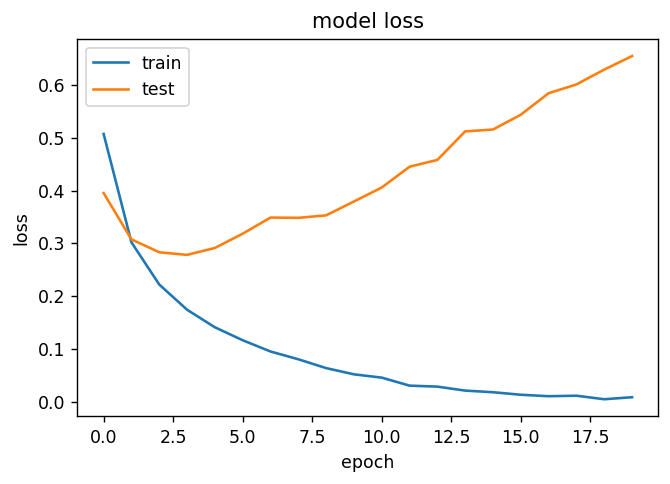

In [17]:
## 1. Plot the training and validation loss as a function of training epoch. Describe what happens during the training in terms of under or overfitting.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

As we can see from the graph that the model is overfitting. A training set is an approach nearly perfect accuracy. 

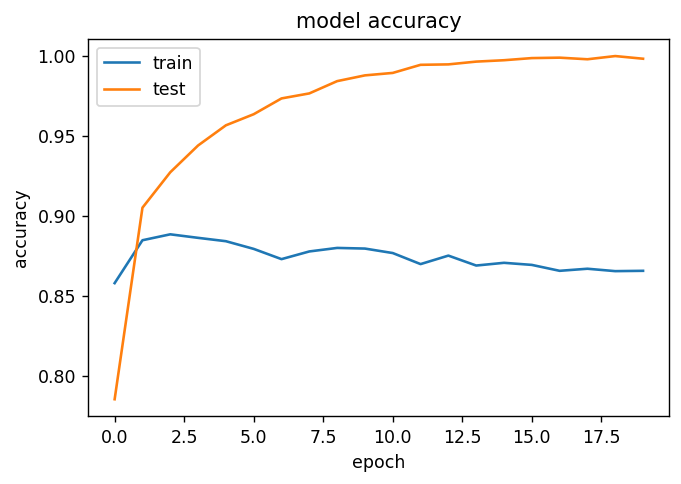

In [18]:
## 2. Plot the training and validation accuracy as a function of the training epoch.
plt.plot(history.history['val_acc'])
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

As per the result, I understood that the network begin to overfit as the epoches are increasing. Which means the model's train accuracy is increasing but the test accuracy or validation accuracy is decreasing with the increase in no.of epochs

#### Early stopping
One simple technique to avoid overfitting is to use the validation set to 'tune' the optimal number of epochs
* In this case, we could stop after 4 epochs


In [19]:
#@title
model.fit(x_train, y_train, epochs=4, batch_size=512, verbose=2)
result = model.evaluate(x_test, y_test)
print("Loss: {:.4f}, Accuracy:  {:.4f}".format(*result))

Epoch 1/4
 - 2s - loss: 0.2271 - acc: 0.9467
Epoch 2/4
 - 2s - loss: 0.1397 - acc: 0.9606
Epoch 3/4
 - 2s - loss: 0.1070 - acc: 0.9684
Epoch 4/4
 - 2s - loss: 0.0870 - acc: 0.9742
25000/25000 [==============================] - 2s 65us/step
Loss: 0.4916, Accuracy:  0.8584


#### Predictions
1. Print the first review that were correctly classified along with the predicted value.
2. Print the first review that were misclassified along with the predicted value. Can you explain why the model likely failed? How confident was the model?

In [0]:
## 1. Print the first review that were correctly classified along with the predicted value.
predicted_classes = model.predict_classes(x_test).reshape(25000)
prediction_probabilities = model.predict(x_test)

In [21]:
correctly_classified = test_labels == predicted_classes
mis_classified = test_labels != predicted_classes

correctly_classified_predictions = test_data[correctly_classified]
misclassified_predictions = test_data[mis_classified]
print(misclassified_predictions[0][0])

print("Correctly classified Prediction:  ".join([reverse_word_index.get(i - 3, "") for i in correctly_classified_predictions[0]]))
print('\n')
print("Missclassified Prediction: ".join([reverse_word_index.get(i - 3, "") for i in misclassified_predictions[0]]))

1
Correctly classified Prediction:  pleaseCorrectly classified Prediction:  giveCorrectly classified Prediction:  thisCorrectly classified Prediction:  oneCorrectly classified Prediction:  aCorrectly classified Prediction:  missCorrectly classified Prediction:  brCorrectly classified Prediction:  brCorrectly classified Prediction:  Correctly classified Prediction:  Correctly classified Prediction:  andCorrectly classified Prediction:  theCorrectly classified Prediction:  restCorrectly classified Prediction:  ofCorrectly classified Prediction:  theCorrectly classified Prediction:  castCorrectly classified Prediction:  renderedCorrectly classified Prediction:  terribleCorrectly classified Prediction:  performancesCorrectly classified Prediction:  theCorrectly classified Prediction:  showCorrectly classified Prediction:  isCorrectly classified Prediction:  flatCorrectly classified Prediction:  flatCorrectly classified Prediction:  flatCorrectly classified Prediction:  brCorrectly classifi

The model is faling because the words in the review are positive but the meaning seems to be sarcastic or negative.



#### Takeaways
* Neural nets require a lot of preprocessing to create tensors
* Dense layers with ReLU activation can solve a wide range of problems
* Binary classification can be done with a Dense layer with a single unit, sigmoid activation, and binary cross-entropy loss
* Neural nets overfit easily
* Many design choices have an effect on accuracy and overfitting. One can try:
    - 1 or 3 hidden layers
    - more or fewer hidden units (e.g. 64)
    - MSE loss instead of binary cross-entropy
    - `tanh` activation instead of `ReLU`

### Regularization: build smaller networks
* The easiest way to avoid overfitting is to use a simpler model
* The number of learnable parameters is called the model _capacity_
* A model with more parameters has a higher _memorization capacity_
    - The entire training set can be `stored` in the weights
    - Learns the mapping from training examples to outputs
* Forcing the model to be small forces it to learn a compressed representation that generalizes better
    - Always a trade-off between too much and too little capacity
* Start with few layers and parameters, incease until you see diminisching returns

Let's try this on our movie review data, with 4 units per layer


In [0]:
from keras.datasets import imdb
import numpy as np

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [23]:
from keras import models
from keras import layers 
import matplotlib.pyplot as plt

original_model = models.Sequential()
original_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
original_model.add(layers.Dense(16, activation='relu'))
original_model.add(layers.Dense(1, activation='sigmoid'))

original_model.compile(optimizer='rmsprop',
                       loss='binary_crossentropy',
                       metrics=['acc'])

smaller_model = models.Sequential()
smaller_model.add(layers.Dense(4, activation='relu', input_shape=(10000,)))
smaller_model.add(layers.Dense(4, activation='relu'))
smaller_model.add(layers.Dense(1, activation='sigmoid'))

smaller_model.compile(optimizer='rmsprop',
                      loss='binary_crossentropy',
                      metrics=['acc'])
original_hist = original_model.fit(x_train, y_train,
                                   epochs=20,
                                   batch_size=512, verbose=2,
                                   validation_data=(x_test, y_test))
smaller_model_hist = smaller_model.fit(x_train, y_train,
                                       epochs=20,
                                       batch_size=512, verbose=2,
                                       validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 4s - loss: 0.4306 - acc: 0.8215 - val_loss: 0.3326 - val_acc: 0.8741
Epoch 2/20
 - 4s - loss: 0.2523 - acc: 0.9112 - val_loss: 0.2920 - val_acc: 0.8845
Epoch 3/20
 - 4s - loss: 0.1983 - acc: 0.9297 - val_loss: 0.2909 - val_acc: 0.8836
Epoch 4/20
 - 4s - loss: 0.1667 - acc: 0.9403 - val_loss: 0.2969 - val_acc: 0.8826
Epoch 5/20
 - 4s - loss: 0.1437 - acc: 0.9491 - val_loss: 0.3298 - val_acc: 0.8736
Epoch 6/20
 - 4s - loss: 0.1257 - acc: 0.9561 - val_loss: 0.3519 - val_acc: 0.8705
Epoch 7/20
 - 4s - loss: 0.1158 - acc: 0.9588 - val_loss: 0.3702 - val_acc: 0.8704
Epoch 8/20
 - 4s - loss: 0.1023 - acc: 0.9642 - val_loss: 0.4024 - val_acc: 0.8641
Epoch 9/20
 - 4s - loss: 0.0916 - acc: 0.9683 - val_loss: 0.4523 - val_acc: 0.8566
Epoch 10/20
 - 4s - loss: 0.0843 - acc: 0.9709 - val_loss: 0.4408 - val_acc: 0.8632
Epoch 11/20
 - 4s - loss: 0.0755 - acc: 0.9756 - val_loss: 0.4903 - val_acc: 0.8570
Epoch 12/20
 - 4s - loss: 0.0678 - 

In [24]:
original_hist

In [25]:
smaller_model_hist

1. Plot the validation loss for the original and smaller models. How does the smaller model behave compared to the original?

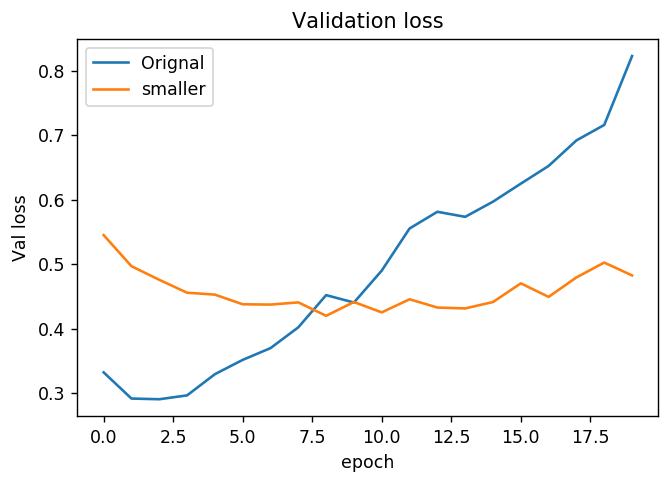

In [26]:
# summarize history for loss
plt.plot(original_hist.history['val_loss'])
plt.plot(smaller_model_hist.history['val_loss'])
plt.title('Validation loss')
plt.ylabel('Val loss')
plt.xlabel('epoch')
plt.legend(['Orignal', 'smaller'], loc='upper left')
plt.show()

Initially, the loss in the smaller model is higher than the loss in the original model. However, as the epochs are increasing the loss in the smaller model is less when compared to the loss in the original model. Which means the smaller model is less overfitting than the original model.

Smaller model v/s original model

### Regularization: Weight regularization
* As we did many times before, we can also add weight regularization to our loss function
- L1 regularization: leads to _sparse networks_ with many weights that are 0
- L2 regularization: leads to many very small weights
    - Also called _weight decay_ in neural net literature
* In Keras, add `kernel_regularizer` to every layer

In [0]:
from keras import regularizers
from keras import models
from keras import layers 
import matplotlib.pyplot as plt

l2_model = models.Sequential()
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu', input_shape=(10000,)))
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'))
l2_model.add(layers.Dense(1, activation='sigmoid'))

In [0]:
l2_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['acc'])

In [29]:
l2_model_hist = l2_model.fit(x_train, y_train,
                             epochs=20,
                             batch_size=512, verbose=2,
                             validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 4s - loss: 0.4939 - acc: 0.8167 - val_loss: 0.3729 - val_acc: 0.8831
Epoch 2/20
 - 4s - loss: 0.3121 - acc: 0.9058 - val_loss: 0.3341 - val_acc: 0.8896
Epoch 3/20
 - 4s - loss: 0.2714 - acc: 0.9196 - val_loss: 0.3390 - val_acc: 0.8846
Epoch 4/20
 - 4s - loss: 0.2530 - acc: 0.9274 - val_loss: 0.3388 - val_acc: 0.8850
Epoch 5/20
 - 4s - loss: 0.2360 - acc: 0.9349 - val_loss: 0.3727 - val_acc: 0.8710
Epoch 6/20
 - 4s - loss: 0.2316 - acc: 0.9343 - val_loss: 0.3484 - val_acc: 0.8820
Epoch 7/20
 - 4s - loss: 0.2244 - acc: 0.9396 - val_loss: 0.3570 - val_acc: 0.8802
Epoch 8/20
 - 4s - loss: 0.2189 - acc: 0.9414 - val_loss: 0.3680 - val_acc: 0.8755
Epoch 9/20
 - 4s - loss: 0.2161 - acc: 0.9417 - val_loss: 0.3697 - val_acc: 0.8774
Epoch 10/20
 - 4s - loss: 0.2132 - acc: 0.9444 - val_loss: 0.3919 - val_acc: 0.8707
Epoch 11/20
 - 4s - loss: 0.2081 - acc: 0.9448 - val_loss: 0.3900 - val_acc: 0.8714
Epoch 12/20
 - 4s - loss: 0.2039 - 

1. Plot the validation loss for the original and l2 regularized models. How does the regularized model behave compared to the original?

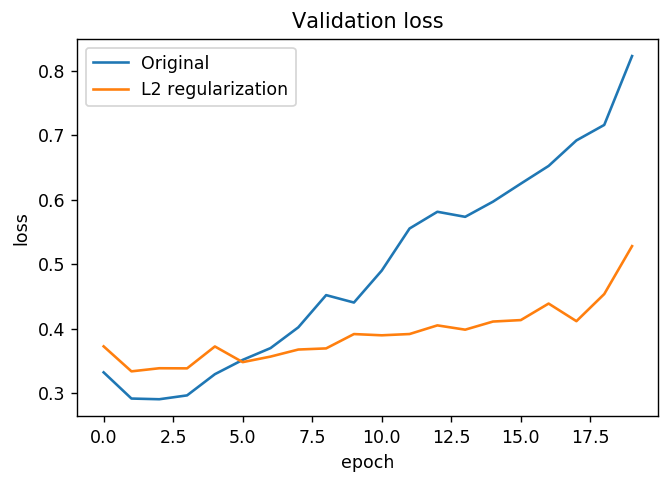

In [30]:
# summarize history for loss

plt.plot(original_hist.history['val_loss'])
plt.plot(l2_model_hist.history['val_loss'])
plt.title('Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Original', 'L2 regularization'], loc='upper left')
plt.show()

The loss of the original model is increasing with increase in the no.of epcohs. But the loss in the l2 model is stable and is oscillating around 0.3 to 0.4. The l2 model is performing better than the original model.

### Regularization: dropout
* One of the most effective and commonly used regularization techniques
* Randomly set a number of outputs of the layer to 0
* Idea: break up accidental non-significant learned patterns 
* _Dropout rate_: fraction of the outputs that are zeroed-out
    - Usually between 0.2 and 0.5
* At test time, nothing is dropped out, but the output values are scaled down by the dropout rate
    - Balances out that more units are active than during training
* In Keras: add `Dropout` layers between the normal layers

In [31]:
from keras import models
from keras import layers 
import matplotlib.pyplot as plt

dpt_model = models.Sequential()
dpt_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(16, activation='relu'))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(1, activation='sigmoid'))

dpt_model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [32]:
dpt_model_hist = dpt_model.fit(x_train, y_train,
                               epochs=20,
                               
                               batch_size=512, verbose=2,
                               validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 4s - loss: 0.5841 - acc: 0.7017 - val_loss: 0.4456 - val_acc: 0.8674
Epoch 2/20
 - 4s - loss: 0.4381 - acc: 0.8281 - val_loss: 0.3524 - val_acc: 0.8755
Epoch 3/20
 - 4s - loss: 0.3686 - acc: 0.8674 - val_loss: 0.3113 - val_acc: 0.8860
Epoch 4/20
 - 4s - loss: 0.3113 - acc: 0.8943 - val_loss: 0.2919 - val_acc: 0.8880
Epoch 5/20
 - 4s - loss: 0.2731 - acc: 0.9101 - val_loss: 0.3114 - val_acc: 0.8836
Epoch 6/20
 - 4s - loss: 0.2476 - acc: 0.9195 - val_loss: 0.2970 - val_acc: 0.8866
Epoch 7/20
 - 4s - loss: 0.2170 - acc: 0.9288 - val_loss: 0.3105 - val_acc: 0.8835
Epoch 8/20
 - 4s - loss: 0.1981 - acc: 0.9343 - val_loss: 0.3258 - val_acc: 0.8801
Epoch 9/20
 - 4s - loss: 0.1884 - acc: 0.9399 - val_loss: 0.3389 - val_acc: 0.8773
Epoch 10/20
 - 4s - loss: 0.1762 - acc: 0.9439 - val_loss: 0.3702 - val_acc: 0.8792
Epoch 11/20
 - 4s - loss: 0.1607 - acc: 0.9496 - val_loss: 0.3835 - val_acc: 0.8787
Epoch 12/20
 - 4s - loss: 0.1494 - 

1. Plot the validation loss for the original and dropout models. How does the dropout model behave compared to the original?

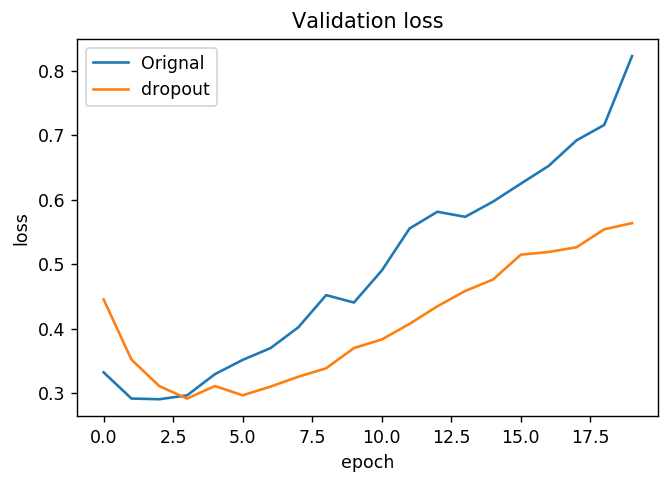

In [33]:
# summarize history for loss
plt.plot(original_hist.history['val_loss'])
plt.plot(dpt_model_hist.history['val_loss'])
plt.title('Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Orignal', 'dropout'], loc='upper left')
plt.show()

The loss of both the original and dropout models are increasing with increase in the no.of epochs. But the dropout model is not overfitting.


### Regularization recap
* Get more training data
* Reduce the capacity of the network
* Add weight regularization
* Add dropout
* Either start with a simple model and add capacity
* Or, start with a complex model and then regularize by adding weight regularization and dropout

### Regression
* Dataset: 506 examples of houses and sale prices (Boston)
    - Included in Keras, with a 1/5 train-test split
* Each row is one house price, described by numeric properties of the house and neighborhood
* Small dataset, non-normalized features

In [34]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

57344/57026 [==============================] - 0s 1us/step


#### Preprocessing
* Neural nets work a lot better if we normalize the features first. 
* Keras has no built-in support so we have to do this manually (or with scikit-learn)
    - Again, be careful not to look at the test data during normalization
    


In [0]:

mean, std = train_data.mean(axis=0), train_data.std(axis=0)
train_data -= mean
train_data /= std

test_data -= mean
test_data /= std

#### Building the network
* This is a small dataset, so easy to overfit
    * We use 2 hidden layers of 64 units each
* Use smaller batches, more epochs
* Since we want scalar output, the output layer is one unit without activation
* Loss function is Mean Squared Error (bigger penalty)
* Evaluation metric is Mean Absolute Error (more interpretable)
* We will also use cross-validation, so we wrap the model building in a function, so that we can call it multiple times

1. Create a function build_model that returns the neural network model described above

In [0]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

#### Cross-validation
* Keras does not have support for cross-validation
* We can implement cross-validation ourselves (seeprovided code below)
* Alternatively, we can wrap a Keras model as a scikit-learn estimator
* Generally speaking, cross-validation is tricky with neural nets
    * Some fold may not converge, or fluctuate on random initialization
    

In [37]:
# implementation of cross-validation
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 20
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=2)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


1. Train for longer (200 epochs) and keep track of loss after every epoch. Plot and describe the loss as a function of epoch number.

In [38]:
from keras import backend as K
K.clear_session() # Memory clean-up

num_epochs = 200
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=2)
    mae_history = history.history['val_loss']
    all_mae_histories.append(mae_history)


processing fold # 0
Train on 303 samples, validate on 101 samples
Epoch 1/200
 - 0s - loss: 210.8488 - mean_absolute_error: 11.2715 - val_loss: 33.4123 - val_mean_absolute_error: 3.6316
Epoch 2/200
 - 0s - loss: 31.0747 - mean_absolute_error: 3.8773 - val_loss: 25.1467 - val_mean_absolute_error: 3.1479
Epoch 3/200
 - 0s - loss: 22.8641 - mean_absolute_error: 3.2317 - val_loss: 19.5261 - val_mean_absolute_error: 3.0381
Epoch 4/200
 - 0s - loss: 19.4873 - mean_absolute_error: 2.9379 - val_loss: 18.2424 - val_mean_absolute_error: 2.7031
Epoch 5/200
 - 0s - loss: 17.6632 - mean_absolute_error: 2.7352 - val_loss: 15.5556 - val_mean_absolute_error: 2.4784
Epoch 6/200
 - 0s - loss: 16.2963 - mean_absolute_error: 2.5966 - val_loss: 13.7246 - val_mean_absolute_error: 2.4665
Epoch 7/200
 - 0s - loss: 14.5866 - mean_absolute_error: 2.5533 - val_loss: 12.8994 - val_mean_absolute_error: 2.2444
Epoch 8/200
 - 0s - loss: 13.9057 - mean_absolute_error: 2.4768 - val_loss: 13.2171 - val_mean_absolute_e

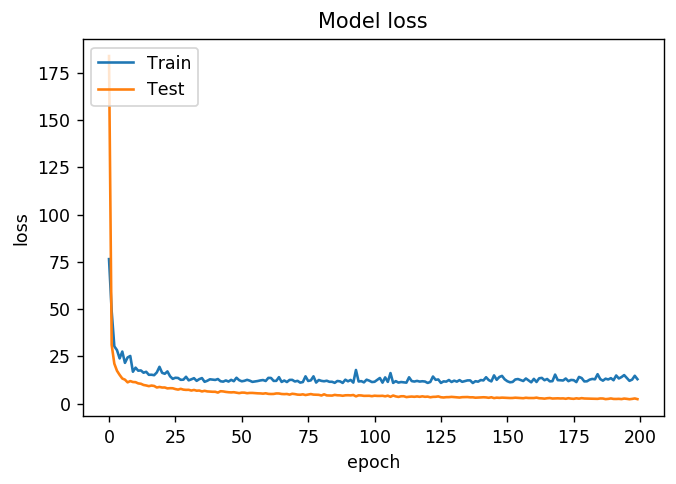

In [39]:
# summarize history for loss
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

The model performed best on training data when compared to the test data. The loss is less on the training data. However, both the training and test loss are minimal. The model is expected to perform better than rest of the models.

#### Takeaways
* Regression is usually done using MSE loss and MAE for evaluation
* Input data should always be scaled (independent from the test set)
* Small datasets:
    - Use cross-validation
    - Use simple (non-deep) networks
    - Smaller batches, more epochs